# Environment setup

In [0]:
# connect to google drive
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

########################################################################################
# SET WORKING DIRECTORY TO PROJECT FOLDER BEFORE RUNNING!!
wd = gdrive_root + '/BiS438 bioinformatics working directory/Project#4/beta-lactamase/'
########################################################################################

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Add, Input, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback

tf.keras.backend.set_floatx('float64')

import numpy as np
import os
import time
import random
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

np.random.seed(0)

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 50.4MB/s 
     |████████████████████████████████| 3.8MB 30.6MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled googl

# Data preprocessing + dataset construction

You are given two datasets (beta-lactamase and IF1). For each dataset, preprocess.py takes in the multiple sequence alignment (training data) and the deep mutational scan data (testing data), and returns the following: 

-	From the multiple sequence alignment (.a2m), (1) train_data.npy: multiple sequence alignment (MSA) sequences in one-hot encoding. The MSA was obtained by running a homology search tool against a target protein sequence.

-	From the deep mutational scan data (.csv), (2) test_data.npy: mutated sequences having single mutations with respect to the target protein sequence and (3) target_values.npy: mutation effect scores for the mutated test sequences.

**./beta-lactamase/preprocess.py execution result**

```
D:\Program_Files\Anaconda3\python.exe "D:/Google_Drive/BiS438 bioinformatics working directory/Project#4/IF1/preprocess.py"
['-', 'Z', 'B', 'P', 'T', 'S', 'K', 'R', 'C', 'H', 'N', 'Q', 'D', 'E', 'W', 'Y', 'F', 'M', 'G', 'A', 'V', 'L', 'I', 'X']
                           name                                           sequence
0                IF1_ECOLI/1-72  mAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIR...
1         UniRef100_Q1AU52/1-70  mAKEDVIEVEGTVTEALPNTQFRVELDNGHNVLAHISGKMRMNYIR...
2     UniRef100_A0A0K2GAM5/1-70  mAKEDVIEVQGTVSETLPNAMFRVKLDNGHMILAHISGKMRMHFIR...
3     UniRef100_A0A0S4KTT2/1-70  mAKEDIIEVQGTVAETLPNAMFRVKLDNGHIILAHISGKMRMHFIR...
4  UniRef100_UPI0003731B62/1-70  mAKEDVIEIEGVVVETLPNAMFNVELENGHEILAHISGKMRMNYIR...
number of data points: 9190
length of sequence: 72
sample sequence: mAKEDNIEMQGTVLETLPNTMFRVELENGHVVTAHISGKMRKNYIRILTGDKVTVELTPYDLSKGRIVFRsr
pruned sequence length: 69
9190
train_data_one_hot: (9190, 69, 24)
number of mutants: 1420
  mutant  fitness_rich
0    A2K      1.069500
1    A2N      1.054500
2    A2T      1.010750
3    A2R      0.981167
4    A2S      1.009167
number of target values: 1380
1380 1380
[('A', 'K'), ('K', 'K'), ('E', 'E'), ('D', 'D'), ('N', 'N'), ('I', 'I'), ('E', 'E'), ('M', 'M'), ('Q', 'Q'), ('G', 'G')]
[('A', 'N'), ('K', 'K'), ('E', 'E'), ('D', 'D'), ('N', 'N'), ('I', 'I'), ('E', 'E'), ('M', 'M'), ('Q', 'Q'), ('G', 'G')]
(1380, 1656)
test_data_one_hot: (1380, 69, 24)

Process finished with exit code 0
```


In [0]:
# minibatch size
BATCH_SIZE = 8

In [0]:
# load data
train_data = np.load(wd + 'train_data.npy', allow_pickle=False)
test_data = np.load(wd + 'test_data.npy', allow_pickle=False)
test_val = np.load(wd + 'target_values.npy', allow_pickle=False)

# show shape
print("train data: " + str(train_data.shape))
print("test data: " + str(test_data.shape))
print("test values: " + str(test_val.shape))

train data: (8403, 253, 24)
test data: (4610, 253, 24)
test values: (4610,)


In [0]:
# process train data
# shuffle training data
np.random.shuffle(train_data)

# pad data with <sos>(unused in vocab)
# pad length: 1
padding = 1

# <sos> as a new category dimension
sos = np.zeros((train_data.shape[0], train_data.shape[1], 1))

# <sos> prefix
pad = np.zeros((train_data.shape[0], padding, train_data.shape[2]+1))
pad[:, :, -1] = 1

# apply padding
train_pad = np.concatenate((train_data, sos), axis=2)
train_pad = np.concatenate((pad, train_pad), axis=1)

# construct keras dataset
dataset = tf.data.Dataset.from_tensor_slices(train_pad)

# shuffle and make minibatches
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# split input and target
# return target in truncated format
def split_input_target(chunk):
    input_text = chunk[:, :, :]
    target_text = chunk[:, padding:, :-1]
    return input_text, target_text

# apply split
dataset = dataset.map(split_input_target)
dataset

<MapDataset shapes: ((8, 254, 25), (8, 253, 24)), types: (tf.float64, tf.float64)>

# Sequence model architecture: 1D autoregressive CNN

You need to build two deep autoregressive generative models, p(x)=p(x_1 )p(x_2| x_1)…p(x_n| x_1,…, x_(n-1)).

You can use dilated causal convolution layers, tf.keras.layers.Conv1D, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D for both proteins.

The only difference between the two models is the optimal kernel size and the number of dilated causal convolution layers. This is because the MSA of each protein family has a different sequence length.

For a kernel size=k and number of dilated causal convolution layers=n, a model with exponentially increasing dilation rate (1, 2, 4, 8, ...) will have a receptive field of 1+(k-1)x(2n-1). For more information, https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7.

The receptive field has to be greater than or equal to the sequence length. We recommend using (k, n) = (5, 6) for beta-lactamase and (k, n) = (6, 4) for IF1. Other hyperparameters can be the same.

**Residual block structure**  
> **Main path:**  
> -> 1D Dilated Causal Conv  
> -> BatchNorm  
> -> ReLU  
> -> Dropout  
> -> 1D Dilated Causal Conv  
> -> BatchNorm  
> -> ReLU  
> -> Dropout  
> **Skip connection:**  
> -> 1D conv  
> -> Batchnorm  

In [0]:
# model capacity
embedding_dim = 64

# receptive field parameters
k = 5
n = 6

# dropout rate
p = 0.2

# learning rate
learning_rate = 1e-4

In [0]:
# custom residual block
def residual_block(x, filters, kernel_size, dilation_rate, stage):

  # define naming basis
  conv_name_base = 'res' + str(stage) + '_branch'
  bn_name_base = 'bn' + str(stage) + '_branch'

  # retrieve numbers of filters
  F1, F2, F3 = filters
  f1, f2, f3 = kernel_size
  d1, d2, d3 = dilation_rate

  # skip connection
  x_skip = Conv1D(filters = F1, kernel_size = f1, dilation_rate = d1,
                         padding = 'causal', name = conv_name_base + '_skip')(x)
  x_skip = BatchNormalization(name = bn_name_base + '_skip')(x_skip)
  x_skip = relu(x_skip)
  x_skip = Dropout(rate=p)(x_skip)

  # main path 1
  x = Conv1D(filters = F2, kernel_size = f2, dilation_rate = d2, 
                   padding = 'causal', name = conv_name_base + '_main1')(x)
  x = BatchNormalization(name = bn_name_base + '_main1')(x)
  x = relu(x)
  x = Dropout(rate=p)(x) 

  # main path 2
  x = Conv1D(filters = F3, kernel_size = f3, dilation_rate = d3,
                    padding = 'causal', name = conv_name_base + '_main2')(x)
  x = BatchNormalization(name = bn_name_base + '_main2')(x)
  x = relu(x)
  x = Dropout(rate=p)(x)

  # add skip
  x = Add()([x, x_skip])
  
  return x

In [0]:
# custom autoregressive CNN
def aCNN(input_shape = (train_data.shape[1]+padding, train_data.shape[2]+1)):
  
  # input
  x_input = Input(input_shape)
  x = x_input
  
  # add residual blocks
  for i in range(n):

    # detect last layer
    final = i==n-1

    # output dimension
    out_dim = (not final)*embedding_dim + final*24

    # number of filters in skip connection, main path 1, main path 2
    filters = (out_dim, embedding_dim, out_dim)

    # kernel size for skip connection, main path 1, main path 2
    kernel_size = (k, k, k)

    # dilation rate for skip connection, main path 1, main path 2
    # 1, 2, 4, ...
    dilation_rate = (2**i, 2**i, 2**i)

    # add residual block
    x = residual_block(x, filters=filters,
                       kernel_size=kernel_size,
                       dilation_rate=dilation_rate,
                       stage=i+1)
  
  # make model
  model = Model(inputs=x_input, outputs=x, name='model')
  return model

In [0]:
model = aCNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 254, 25)]    0                                            
__________________________________________________________________________________________________
res1_branch_main1 (Conv1D)      (None, 254, 64)      8064        input_2[0][0]                    
__________________________________________________________________________________________________
bn1_branch_main1 (BatchNormaliz (None, 254, 64)      256         res1_branch_main1[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Relu_19 (TensorFlow [(None, 254, 64)]    0           bn1_branch_main1[0][0]           
______________________________________________________________________________________________

In [0]:
# check model prediction
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print("prediction tensor shape: " + str(example_batch_predictions.shape))

prediction tensor shape: (8, 254, 24)


In [0]:
# process test data

# pad data with <sos>(unused in vocab)
# pad length: 1
padding = 1

# <sos> as a new category dimension
sos = np.zeros((test_data.shape[0], test_data.shape[1], 1))

# <sos> prefix
pad = np.zeros((test_data.shape[0], padding, test_data.shape[2]+1))
pad[:, :, -1] = 1

# apply padding
test_pad = np.concatenate((test_data, sos), axis=2)
test_pad = np.concatenate((pad, test_pad), axis=1)

# split input and target
# return target in truncated format
def split_input_target(chunk):
    input_text = chunk[:, :, :]d
    target_text = chunk[:, padding:, :-1]
    return input_text, target_text

# apply split
test_dataset = split_input_target(test_pad)
print(test_dataset[0].shape)
print(test_dataset[1].shape)

(4610, 254, 25)
(4610, 253, 24)


# Training

When training the model, you should use negative log likelihood (softmax cross entropy) between the input and the output. 

- loss: cross-entropy
- optimizer: Adam
- learning rate: 1e-4
- training epochs: 5
- minibatch size: 8

**training loss vs. epoch**

<div>
<img src=https://drive.google.com/uc?export=download&id=1YbNdTQ-8BhR23vmAyajbdeT7HRKmSVQi height="300"/>
</div>

In [0]:
# sequence length
seq_len = test_dataset[1].shape[1]
print("sequence length: %d" % seq_len)

# define cross-entropy loss
def loss(labels, logits):
  # labels: truncated one-hot
  # logits: untruncated pseudo-probabilities
  return seq_len*tf.keras.losses.categorical_crossentropy(labels[:,:,:],
                                                  logits[:,:-padding,:],
                                                  from_logits=True)

# show example
example_batch_loss  = loss(target_example_batch,
                           example_batch_predictions)
print("predicted array shape: ", example_batch_predictions.shape)
print("scalar loss: ", example_batch_loss.numpy().mean())
print("predicted mutation effect: ", -example_batch_loss.numpy().mean())

sequence length: 253
predicted array shape:  (8, 254, 24)
scalar loss:  802.55176247506
predicted mutation effect:  -802.55176247506


In [0]:
rand_sample = np.random.choice(test_data.shape[0], 100)

eval_subset = (test_dataset[0][rand_sample,:,:],
               test_dataset[1][rand_sample,:,:])
target_subset = test_val[rand_sample]

# test data evaluation
def eval(model, eval_subset=test_dataset, target_subset=test_val):
  print("evaluating...")
  mutation_effect = np.zeros(eval_subset[0].shape[0])
  
  # predict one by one
  for i in range(eval_subset[0].shape[0]):
    if i%100==0:
      print("eval step %d/%d" % (i, eval_subset[0].shape[0]))

    test_input =  np.expand_dims(eval_subset[0][i,:,:], axis=0)
    test_target =  np.expand_dims(eval_subset[1][i,:,:], axis=0)
    predictions = model(test_input)
    mutation_effect[i] = -loss(test_target, predictions).numpy().sum()
  
  rho, pval = spearmanr(mutation_effect, target_subset)
  return (rho, pval)

# evaluate from randomly sampled 100 subsamples in train data
print(eval(model,
           eval_subset=eval_subset,
           target_subset=target_subset))

evaluating...
eval step 0/100
(0.028438294204055404, 0.7788144449747081)


In [0]:
# set model-saving checkpoints
checkpoint_dir = wd + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set checkpoint saving callback
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# set evaluation callback
eval_log = []
class TestCallback(Callback):
    def __init__(self):
      pass

    def on_epoch_end(self, epoch, logs={}):
      print("\neval start")
      rho, pval = eval(self.model,
                       eval_subset=eval_subset,
                       target_subset=target_subset)
      print('\nSpearman correlation coef with test data: {}\n'.format(rho))
      eval_log.append(rho)

In [0]:
# train the model
EPOCHS = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback, TestCallback()], verbose=1)

Epoch 1/5
   1050/Unknown - 58s 55ms/step - loss: 791.4585
eval start
evaluating...
eval step 0/100

Spearman correlation coef with test data: 0.3719241608311766

1050/1050 [==============================] - 68s 65ms/step - loss: 791.4585
Epoch 2/5
1048/1050 [============================>.] - ETA: 0s - loss: 673.7754
eval start
evaluating...
eval step 0/100

Spearman correlation coef with test data: 0.46313793418033083

1050/1050 [==============================] - 59s 56ms/step - loss: 673.7287
Epoch 3/5
1049/1050 [============================>.] - ETA: 0s - loss: 597.1378
eval start
evaluating...
eval step 0/100

Spearman correlation coef with test data: 0.5209566648526401

1050/1050 [==============================] - 55s 53ms/step - loss: 597.1378
Epoch 4/5
1049/1050 [============================>.] - ETA: 0s - loss: 563.0516
eval start
evaluating...
eval step 0/100

Spearman correlation coef with test data: 0.5480807606117308

1050/1050 [==============================] - 57s 54ms/st

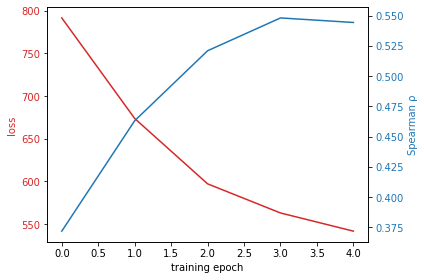

In [0]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('training epoch')
ax1.set_ylabel('loss', color=color)
ax1.plot(history.history['loss'], color=color, label='training loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Spearman ρ', color=color)  # we already handled the x-label with ax1
ax2.plot(eval_log, color=color, label = 'Spearman ρ')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Testing

When testing the model, you should compute the spearman rank correlation (“from scipy.stats import spearmanr”) between the target values and the model-predicted mutation effects (you can use the keras callback for evaluating the spearman correlation during training, https://github.com/keras-team/keras/issues/2548).

The model-predicted mutation effects are computed using the log likelihood (logp) of the mutant sequence, which is equivalent to the negative of the loss.


<div>
<img src=https://drive.google.com/uc?export=download&id=1k2tqfoqZ_DQimq7vOOk-ZJVIgekkvSII height="500"/>
</div>

**Benchmark result for beta-lactamase: Spearman ρ~0.78**

**1D autoregressive CNN: Spearman ρ=0.58**

```
evaluating...
eval step 0/4610
eval step 100/4610
eval step 200/4610
eval step 300/4610
eval step 400/4610
eval step 500/4610
eval step 600/4610
eval step 700/4610
eval step 800/4610
eval step 900/4610
eval step 1000/4610
eval step 1100/4610
eval step 1200/4610
eval step 1300/4610
eval step 1400/4610
eval step 1500/4610
eval step 1600/4610
eval step 1700/4610
eval step 1800/4610
eval step 1900/4610
eval step 2000/4610
eval step 2100/4610
eval step 2200/4610
eval step 2300/4610
eval step 2400/4610
eval step 2500/4610
eval step 2600/4610
eval step 2700/4610
eval step 2800/4610
eval step 2900/4610
eval step 3000/4610
eval step 3100/4610
eval step 3200/4610
eval step 3300/4610
eval step 3400/4610
eval step 3500/4610
eval step 3600/4610
eval step 3700/4610
eval step 3800/4610
eval step 3900/4610
eval step 4000/4610
eval step 4100/4610
eval step 4200/4610
eval step 4300/4610
eval step 4400/4610
eval step 4500/4610
eval step 4600/4610
(0.5883050882249273, 0.0)
```

In [0]:
# load checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

'/gdrive/My Drive/BiS438 bioinformatics working directory/Project#4/beta-lactamase//training_checkpoints/ckpt_5'

In [0]:
# build model that processes 1 example at a time
# import trained weights
model = aCNN()
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.summary()
eval(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 254, 25)]    0                                            
__________________________________________________________________________________________________
res1_branch_main1 (Conv1D)      (None, 254, 64)      8064        input_3[0][0]                    
__________________________________________________________________________________________________
bn1_branch_main1 (BatchNormaliz (None, 254, 64)      256         res1_branch_main1[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Relu_37 (TensorFlow [(None, 254, 64)]    0           bn1_branch_main1[0][0]           
______________________________________________________________________________________________

(0.5883050882249273, 0.0)